In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
import seaborn as sns
sns.set()

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

from keras.datasets import cifar10
optimizer = optimizers.sgd(lr=0.0001)
EPOCHS = 20


Using TensorFlow backend.


# Introduction
In this assignment, we compare three strategies for training CNNs on a image classification problem, with two of those strategies using Transfer Learning. 

Transfer learning or inductive transfer is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 

Here, we use the the [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


# Loading Input Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


# Data Examples

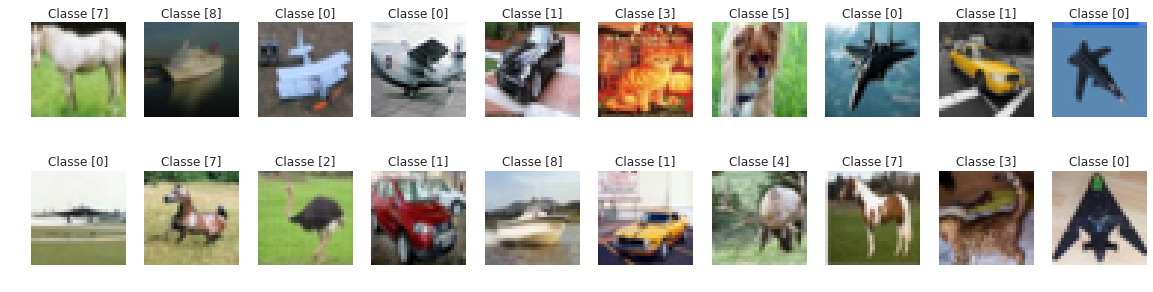

In [3]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Classe {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

In [0]:
# Normalizing pixels to [0, 1] interval
x_train = x_train/255
x_test = x_test/255


# Splitting Data Into Groups
In order to use transfer learning, we'll  split the data into two groups A and B. The latter will comprehend classes 0 and 7 and the former will comprehend the remaining groups. 

In [0]:
# Creating one-hot encoding and reshaping data
y_train =  np.reshape(y_train, (len(y_train)))
y_test =  np.reshape(y_test, (len(y_test)))
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_train = y_train.values
y_test = y_test.values


In [6]:
y_test.shape

(10000, 10)

In [7]:
x_test.shape

(10000, 32, 32, 3)

In [8]:
# A/B goup splitting

Ax_train = []
Ay_train = []
Ax_test = []
Ay_test = []

Bx_train = []
By_train = []
Bx_test = []
By_test = []

# Now that the data is in one-hot, we need get_index method to retrieve an image's class
def get_index(x):
  for i in range(len(x)):
    if(x[i]==1):
      return i
    
for i in range(len(y_test)):
  if(get_index(y_test[i])==0 or get_index(y_test[i])==7):
    By_test.append(y_test[i])
    Bx_test.append(x_test[i])
  else:
    Ay_test.append(y_test[i])
    Ax_test.append(x_test[i])
    
for i in range(len(y_train)):
  if(get_index(y_train[i])==0 or get_index(y_train[i])==7):
    By_train.append(y_train[i])
    Bx_train.append(x_train[i])
  else:
    Ay_train.append(y_train[i])
    Ax_train.append(x_train[i])
    

# Casting to numpy array
By_test = np.array(By_test)
Bx_test = np.array(Bx_test)

Ay_test = np.array(Ay_test)
Ax_test = np.array(Ax_test)

By_train = np.array(By_train)
Bx_train = np.array(Bx_train)

Ay_train = np.array(Ay_train)
Ax_train = np.array(Ax_train)

Bx_test.shape

(2000, 32, 32, 3)

## Graphs
For all graphs created, the legends will follow this standard:
*   M 1: CNN trained with set A 
*   M 2: CNN trained with set B, without transfer learning
*   M 3: CNN trained with set B, with fine tunning on the last layer
*   M 4: CNN trained with set B, with fine tunning on the last two layers


# CNN Trained With Set A

Here, we declare a CNN with 4 convolution layers, two max pooling layers and two fully connected layers at the end. For all layers, we use ReLU as the activation function, except for the last one, which uses softmax. To add regularization, we also use two dropout layers.

In [0]:
n_classes = 10
modelA = models.Sequential()
modelA.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", input_shape=(32,32,3)))
modelA.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2"))
modelA.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"))

modelA.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3"))
modelA.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4"))
modelA.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool2"))


modelA.add(layers.Flatten(name="Flatten"))
modelA.add(layers.Dense(128, activation="relu", name="Dense1"))
modelA.add(layers.Dropout(0.4, name="Dropout"))
modelA.add(layers.Dense(n_classes, activation='softmax', name="Output"))
modelA.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
result_a = modelA.fit(Ax_train,Ay_train,verbose=1,epochs=EPOCHS,validation_data=(Ax_test,Ay_test))

Train on 40000 samples, validate on 8000 samples
Epoch 1/20
40000/40000 [==============================] - 25s 626us/step - loss: 2.2974 - acc: 0.1141 - val_loss: 2.2810 - val_acc: 0.1466
Epoch 2/20
40000/40000 [==============================] - 18s 459us/step - loss: 2.2680 - acc: 0.1335 - val_loss: 2.2512 - val_acc: 0.1606
Epoch 3/20
40000/40000 [==============================] - 18s 459us/step - loss: 2.2366 - acc: 0.1345 - val_loss: 2.2113 - val_acc: 0.1675
Epoch 4/20
40000/40000 [==============================] - 18s 454us/step - loss: 2.1968 - acc: 0.1411 - val_loss: 2.1662 - val_acc: 0.1719
Epoch 5/20
40000/40000 [==============================] - 18s 453us/step - loss: 2.1656 - acc: 0.1416 - val_loss: 2.1311 - val_acc: 0.1718
Epoch 6/20
40000/40000 [==============================] - 18s 456us/step - loss: 2.1450 - acc: 0.1445 - val_loss: 2.1074 - val_acc: 0.1756
Epoch 7/20
40000/40000 [==============================] - 18s 456us/step - loss: 2.1325 - acc: 0.1463 - val_loss: 2.0

In [0]:
# This method plots loss OR acc, given training/validation results for a model
def plot_acc_loss(result,title,label1,label2,type_label):
  train_acc = result.history[type_label]
  test_acc = result.history["val_"+type_label]
  epochs_list = list(range(1,len(train_acc)+1))
  plt.plot(epochs_list,train_acc,color="r",label=label1)
  plt.plot(epochs_list,test_acc,color="b",label=label2)
  plt.xticks(epochs_list)
  plt.legend()
  plt.title(title)
  plt.show()
  
# This method plots acc and loss in testing so we can compare um increase while
# the other decreases
def plot_compare_acc_loss(result,title):
  test_acc = result.history["val_acc"]
  test_loss = result.history["val_loss"]
  epochs_list = list(range(1,len(test_acc)+1))
  plt.plot(epochs_list,test_acc,color="r",label="Test Acc")
  plt.plot(epochs_list,test_loss,color="b",label="Test Loss")
  plt.xticks(epochs_list)
  plt.legend()
  plt.title(title)
  plt.show()


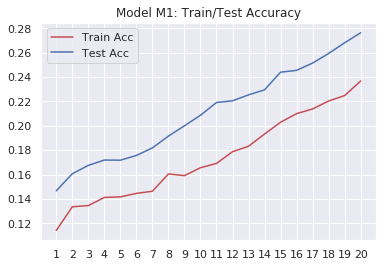

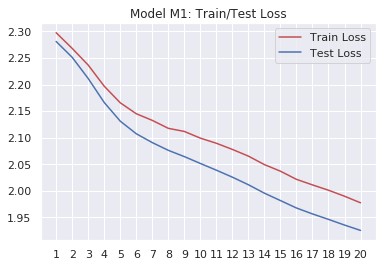

In [12]:
plot_acc_loss(result_a,"Model M1: Train/Test Accuracy","Train Acc","Test Acc","acc")
plot_acc_loss(result_a,"Model M1: Train/Test Loss","Train Loss","Test Loss","loss")

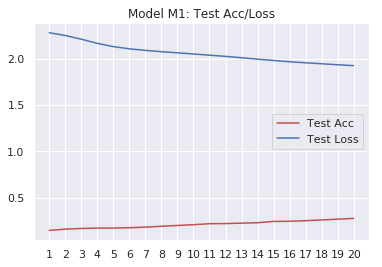

In [13]:
plot_compare_acc_loss(result_a,"Model M1: Test Acc/Loss")

Model converges, without overfitting.

# CNN Without Transfer Learning

Here, we use the same architecture from the previous CNN, but this network will use the B set as training data and does not use transfer learning.

In [0]:
n_classes = 10
modelB = models.Sequential()
modelB.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", input_shape=(32,32,3)))
modelB.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2"))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"))

modelB.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3"))
modelB.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4"))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool2"))


modelB.add(layers.Flatten(name="Flatten"))
modelB.add(layers.Dense(128, activation="relu", name="Dense1"))
modelB.add(layers.Dropout(0.4, name="Dropout"))
modelB.add(layers.Dense(n_classes, activation='softmax', name="Output"))
modelB.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



In [15]:
result_b1 = modelB.fit(Bx_train,By_train,verbose=1,epochs=EPOCHS,validation_data=(Bx_test,By_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 496us/step - loss: 2.2770 - acc: 0.2137 - val_loss: 2.1961 - val_acc: 0.4995
Epoch 2/20
10000/10000 [==============================] - 5s 452us/step - loss: 2.0977 - acc: 0.4929 - val_loss: 1.9596 - val_acc: 0.5000
Epoch 3/20
10000/10000 [==============================] - 5s 453us/step - loss: 1.7477 - acc: 0.5126 - val_loss: 1.4356 - val_acc: 0.5000
Epoch 4/20
10000/10000 [==============================] - 5s 456us/step - loss: 1.2077 - acc: 0.5034 - val_loss: 0.9240 - val_acc: 0.5005
Epoch 5/20
10000/10000 [==============================] - 4s 450us/step - loss: 0.9301 - acc: 0.5088 - val_loss: 0.7762 - val_acc: 0.5540
Epoch 6/20
10000/10000 [==============================] - 5s 452us/step - loss: 0.8554 - acc: 0.5126 - val_loss: 0.7338 - val_acc: 0.5525
Epoch 7/20
10000/10000 [==============================] - 5s 451us/step - loss: 0.8220 - acc: 0.5168 - val_loss: 0.7154 - v

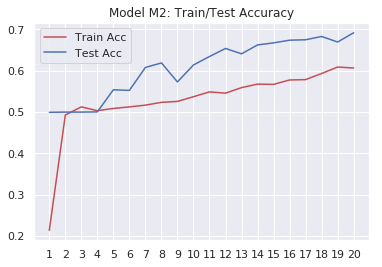

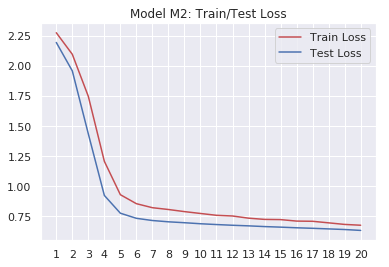

In [16]:
plot_acc_loss(result_b1,"Model M2: Train/Test Accuracy","Train Acc","Test Acc","acc")
plot_acc_loss(result_b1,"Model M2: Train/Test Loss","Train Loss","Test Loss","loss")

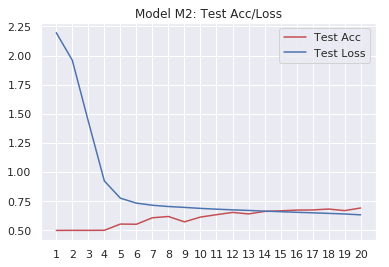

In [17]:
plot_compare_acc_loss(result_b1,"Model M2: Test Acc/Loss")

Accuracy increases and loss decreases. No overfitting.

# Fine-tunning on One Layer
Now, we'll use the weights learned while training a CNN with set A. However, we will train only the last fully-connected layer. Toa achive this goal, we will remove the last layer, freeze the newtork's weights and add a new fully-connected layer that is identical to the one we removed, that will be trained with set B.

In [0]:

modelA.pop()
modelA.trainable = False
modelA.add(layers.Dense(n_classes, activation='softmax', name="Output2"))
modelA.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [19]:
result_b2 = modelA.fit(Bx_train,By_train,epochs=EPOCHS,validation_data=(Bx_test,By_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 496us/step - loss: 1.3004 - acc: 0.4502 - val_loss: 0.8309 - val_acc: 0.5135
Epoch 2/20
10000/10000 [==============================] - 4s 448us/step - loss: 0.9091 - acc: 0.5103 - val_loss: 0.7450 - val_acc: 0.5465
Epoch 3/20
10000/10000 [==============================] - 4s 448us/step - loss: 0.8505 - acc: 0.5084 - val_loss: 0.7146 - val_acc: 0.5855
Epoch 4/20
10000/10000 [==============================] - 5s 451us/step - loss: 0.8081 - acc: 0.5255 - val_loss: 0.6973 - val_acc: 0.5900
Epoch 5/20
10000/10000 [==============================] - 5s 453us/step - loss: 0.7698 - acc: 0.5455 - val_loss: 0.6850 - val_acc: 0.6120
Epoch 6/20
10000/10000 [==============================] - 5s 452us/step - loss: 0.7551 - acc: 0.5517 - val_loss: 0.6756 - val_acc: 0.6115
Epoch 7/20
10000/10000 [==============================] - 5s 451us/step - loss: 0.7448 - acc: 0.5564 - val_loss: 0.6686 - v

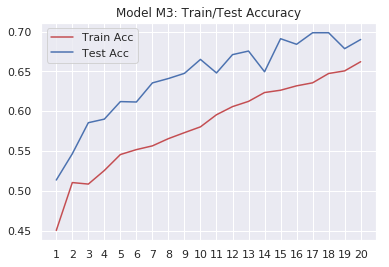

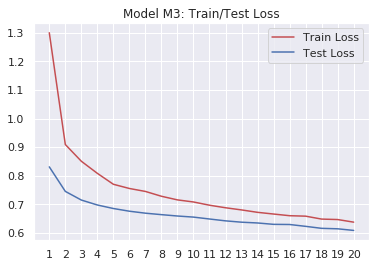

In [20]:
plot_acc_loss(result_b2,"Model M3: Train/Test Accuracy","Train Acc","Test Acc","acc")
plot_acc_loss(result_b2,"Model M3: Train/Test Loss","Train Loss","Test Loss","loss")

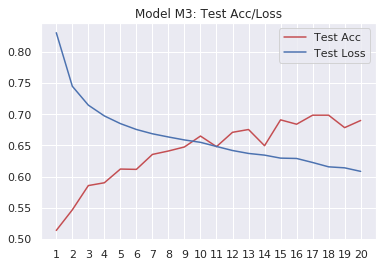

In [21]:
plot_compare_acc_loss(result_b2,"Model M3: Test Acc/Loss")

No overfitting

# Fine-tuning on Two Layers
Here, we will perform as similar task as the last sections', but with fine-tunning on the last two layers.

In [22]:
modelA.pop()
modelA.pop()
modelA.pop()
modelA.trainable = False
modelA.add(layers.Dense(128, activation="relu", name="Dense2"))
modelA.add(layers.Dropout(0.4, name="Dropout23"))
modelA.add(layers.Dense(n_classes, activation='softmax', name="Output3"))
modelA.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

result_b3 = modelA.fit(Bx_train,By_train,epochs=EPOCHS,validation_data=(Bx_test,By_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 491us/step - loss: 1.0480 - acc: 0.4891 - val_loss: 0.7291 - val_acc: 0.5635
Epoch 2/20
10000/10000 [==============================] - 4s 450us/step - loss: 0.8465 - acc: 0.5177 - val_loss: 0.6929 - val_acc: 0.6220
Epoch 3/20
10000/10000 [==============================] - 4s 450us/step - loss: 0.7916 - acc: 0.5422 - val_loss: 0.6738 - val_acc: 0.6500
Epoch 4/20
10000/10000 [==============================] - 5s 456us/step - loss: 0.7529 - acc: 0.5669 - val_loss: 0.6570 - val_acc: 0.6635
Epoch 5/20
10000/10000 [==============================] - 5s 453us/step - loss: 0.7429 - acc: 0.5677 - val_loss: 0.6470 - val_acc: 0.6785
Epoch 6/20
10000/10000 [==============================] - 5s 452us/step - loss: 0.7129 - acc: 0.5929 - val_loss: 0.6363 - val_acc: 0.6845
Epoch 7/20
10000/10000 [==============================] - 5s 453us/step - loss: 0.7006 - acc: 0.6036 - val_loss: 0.6290 - v

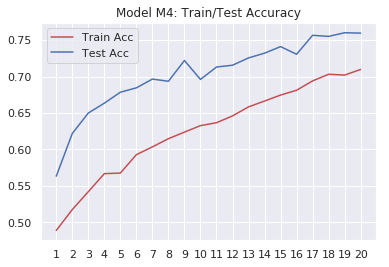

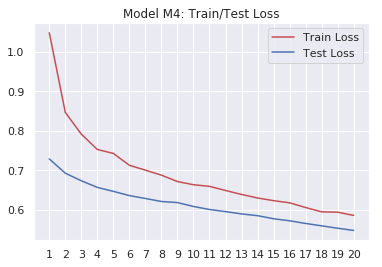

In [23]:
plot_acc_loss(result_b3,"Model M4: Train/Test Accuracy","Train Acc","Test Acc","acc")
plot_acc_loss(result_b3,"Model M4: Train/Test Loss","Train Loss","Test Loss","loss")

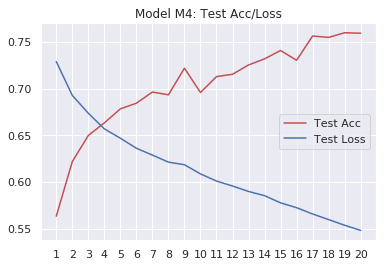

In [24]:
plot_compare_acc_loss(result_b3,"Model M4: Test Acc/Loss")

Model converges correctly

# Comparing Results



### Accuracy Comparison

In [0]:
# Plotting model comparisons

def compare_models(result_a,result_b1,result_b2,result_b3,label,title):
  list_a = result_a.history[label]
  list_b1 = result_b1.history[label]
  list_b2 = result_b2.history[label]
  list_b3 = result_b3.history[label]
  plt.plot(list_a,color="r",label="M 1")
  plt.plot(list_b1,color="b",label="M 2")
  plt.plot(list_b2,color="g",label="M 3")
  plt.plot(list_b3,color="y",label="M 4")
  plt.title(title)
  plt.xticks(list(range(1,len(list_a)+1)))
  plt.legend()
  plt.show()
  


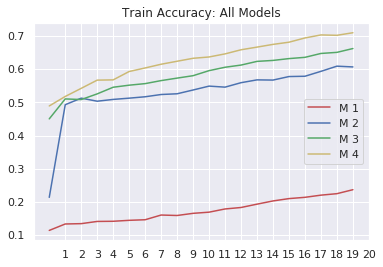

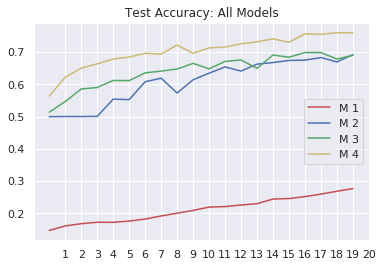

In [26]:
compare_models(result_a,result_b1,result_b2,result_b3,"acc","Train Accuracy: All Models")
compare_models(result_a,result_b1,result_b2,result_b3,"val_acc","Test Accuracy: All Models")

The best results were achieved by the models that used transfer learning, be it for training or testing. The model with the best overall result was the one that used fine-tunning on two layers.

### Loss Comparison

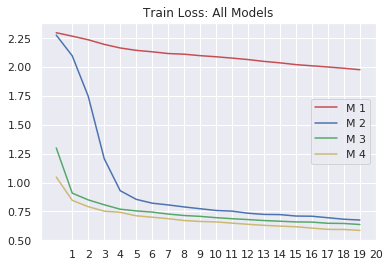

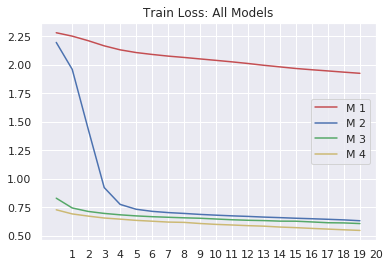

In [27]:
compare_models(result_a,result_b1,result_b2,result_b3,"loss","Train Loss: All Models")
compare_models(result_a,result_b1,result_b2,result_b3,"val_loss","Train Loss: All Models")

Correspondingly, models that used transfer-learning were the ones with the lowest loss values, with the overall lowest being model M4. Furthermore, all models converge correctly, without overfitting.

# Conclusion

The best results for accuracy and loss, for both train and test were achieved by model M 4, which uses transfer learning on the last two fully conencted layers. By using transfer learning, we use pre-trained weights for the convolution layers. That means that the neural net has already learned to recognize patterns that will also be useful to classify other images, such as curves and simple shapes. Furthermore, by training only the fully connected layers, the neural net will use shapes learned on one dataset to learn caracteristics that will help classify images of another dataset.